In [1]:
#Install packages 
!pip install -q datasets 
!pip install tqdm --upgrade 
!pip install pillow 
!pip install torchvision 
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install evaluate
!pip install jiwer
!pip install transformers[torch] 
!pip install accelerate -U

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.6 MB 11.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.6 MB 9.5 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 8.7 MB/s eta 0:00:01
   ------------------------ --------------- 1.5/2.6 MB 8.9 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.6 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 9.1 MB/s eta 0:00:00
  Using cached MarkupSafe-2.1.5-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------------- ------------------------- 0.4/1.2 MB 9.3 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.2 MB 9.5 MB/s eta 0:00:01
   -----------------------------------

In [23]:
# Imports 
import os 
import json 
import torch 
import matplotlib.pyplot as plt
from evaluate import load
from datasets import load_dataset 
from tqdm.notebook import tqdm 
from torch.utils.data import Dataset, DataLoader 
from transformers import AutoProcessor, AutoModelForCausalLM

In [5]:
# Defining data paths 
DATA_PATHS = {
    "raw_dataset_path": "dataset/", 
    "image_set_path": "complete_image_set/train", 
    "checkpoints_dir": "checkpoints/", 
    "save_model_dir": "checkpoints/model/"
}

#### Create metadata.jsonl file 

The dataset is organized as directed on the huggingface documentation on creating an image dataset https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset
    
Captions structure :

    [{file_name: "404/404.png", "prompt": "This is a 404 page design"}]

In [3]:
captions = []
for category in os.listdir(DATA_PATHS["raw_dataset_path"]): 
    for file in os.listdir(f"{DATA_PATHS['raw_dataset_path']}/{category}/images/"):
        with open(f"{DATA_PATHS['raw_dataset_path']}/{category}/prompts/{file.split('.')[0]}.txt", "r") as f: 
            prompts = f.readlines()

            for prompt in prompts: 
                captions.append({"file_name": f"{category}/{file}", "prompts": prompt.split('\n')[0]})

In [4]:
# add metadata.jsonl file to this folder
with open(f"{DATA_PATHS['image_set_path']}/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

### Define and Preprocess Datasets 

In [6]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.max_text_length=512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["prompts"], return_tensors="pt")
        
        # Padding 
        input_ids = encoding["input_ids"].tolist()[0]
        attention_mask = encoding["attention_mask"].tolist()[0]
        
        encoding["input_ids"] = torch.tensor(input_ids + [0] * (self.max_text_length - len(input_ids)))
        encoding["attention_mask"] = torch.tensor(attention_mask + [0] * (self.max_text_length - len(attention_mask))) 
        encoding.update({"labels": encoding["input_ids"]})
                                                          
        # Remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding     

In [7]:
dataset = load_dataset("imagefolder", data_dir=DATA_PATHS["image_set_path"], split="train", drop_labels=False)
train_dataset, test_dataset = dataset.train_test_split(train_size=108, test_size=12).values()

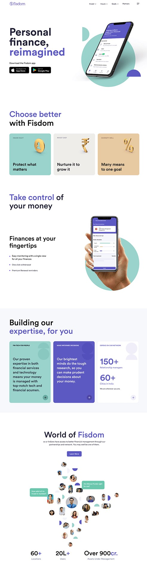

In [8]:
example = train_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [9]:
processor = AutoProcessor.from_pretrained("microsoft/git-base", kwargs="padding")

In [10]:
train_ds = ImageCaptioningDataset(train_dataset, processor)
test_ds = ImageCaptioningDataset(test_dataset, processor)

In [11]:
item = train_ds[0]
for k,v in item.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])
labels torch.Size([512])


In [12]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=40)
test_dataloader = DataLoader(test_ds, shuffle=True, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([40, 512])
attention_mask torch.Size([40, 512])
pixel_values torch.Size([40, 3, 224, 224])
labels torch.Size([40, 512])


### Fine-tuning

In [14]:
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=DATA_PATHS["checkpoints_dir"],
    learning_rate=5e-5,
    num_train_epochs=2,
    gradient_accumulation_steps=2,
    save_total_limit=1,
    evaluation_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_steps=1,
    logging_steps=1,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [17]:
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Wer Score
1,11.936400,10.288510,23.382716
2,10.321500,9.875512,20.753086
3,9.922400,9.589058,23.860082
4,9.647700,9.356904,27.613169
5,9.398900,9.172033,32.407407
6,9.222700,9.023215,33.197531
7,9.100900,8.910361,32.510288
8,8.992200,8.816246,32.864198
9,8.887600,8.731063,33.794239
10,8.812300,8.666756,33.555556


TrainOutput(global_step=14, training_loss=9.356937885284424, metrics={'train_runtime': 743.159, 'train_samples_per_second': 0.291, 'train_steps_per_second': 0.019, 'total_flos': 101019449769984.0, 'train_loss': 9.356937885284424, 'epoch': 2.0})

In [19]:
# Plot loss curves 
def plot_loss_curve(ax, train_losses, plot_title): 
    ax.plot(train_losses, label=plot_title, color='blue')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.set_title(plot_title)
    ax.legend()
    ax.grid(True)

In [20]:
track_losses = ["loss", "eval_loss", "eval_wer_score"]
losses = {key: [record[key] for record in trainer.state.log_history if key in record] for key in track_losses}

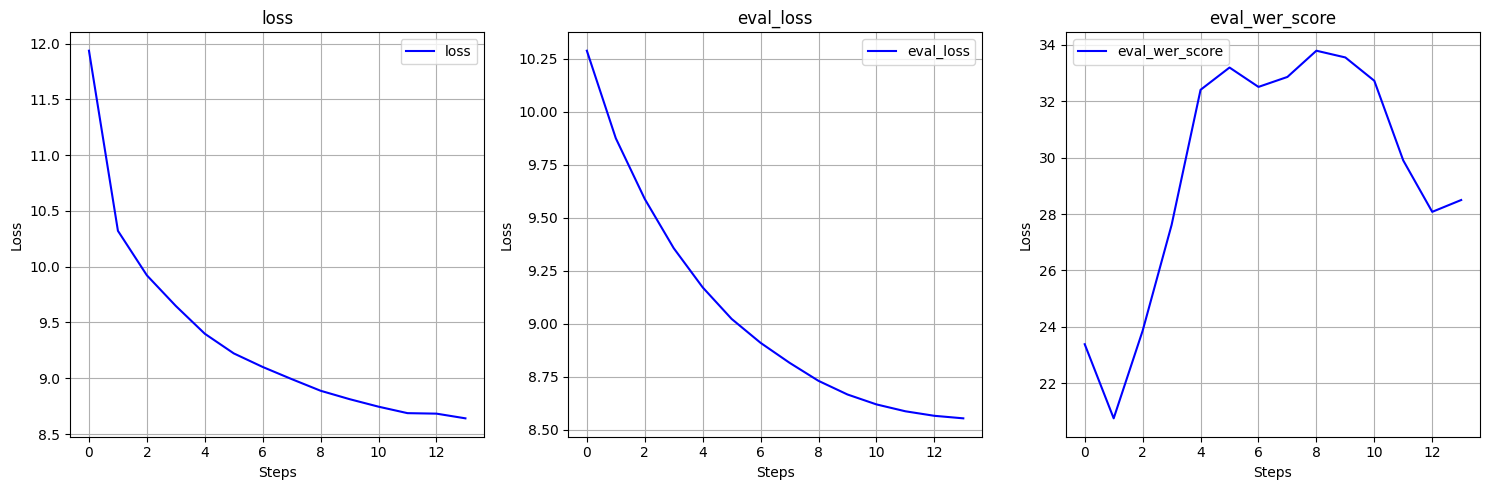

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index, loss in enumerate(track_losses): 
    plot_loss_curve(axs[index], losses[loss], loss)

plt.tight_layout()
plt.show()

In [25]:
# Save the model 
trainer.save_model(DATA_PATHS["save_model_dir"])

### Inference

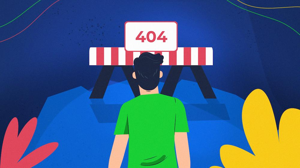

In [23]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [24]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

animated blob shaped illustration based 404 page design with a purple and white color scheme
